In [16]:
from datetime import datetime
import sys

import importlib
from joblib import Parallel, delayed
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from utils import data_utils, data_loader, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/debug/"
NETWORK = "kcm"

In [17]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

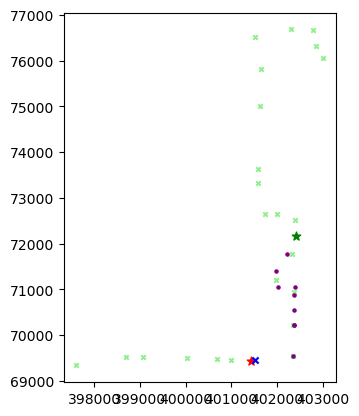

In [18]:
# Look at a single trip
test_traces = kcm_inputs['test_traces']
shingle_data = test_traces[test_traces['shingle_id']==np.unique(test_traces.shingle_id)[0]]
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], kcm_inputs['gtfs_data'], kcm_inputs['config']['epsg'])
shape_utils.plot_gtfsrt_trip(axes, plot_data, kcm_inputs['config']['epsg'])

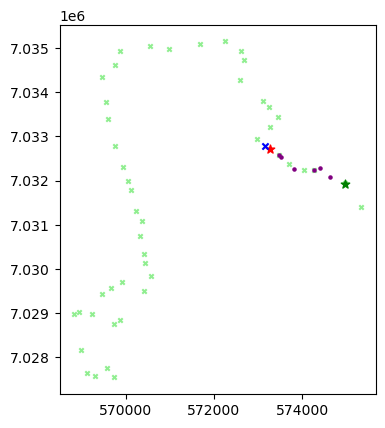

In [19]:
# Look at a single trip
test_traces = atb_inputs['test_traces']
shingle_data = test_traces[test_traces['shingle_id']==np.unique(test_traces.shingle_id)[0]]
shingle_data.head()
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], atb_inputs['gtfs_data'], atb_inputs['config']['epsg'])
shape_utils.plot_gtfsrt_trip(axes, plot_data, atb_inputs['config']['epsg'])

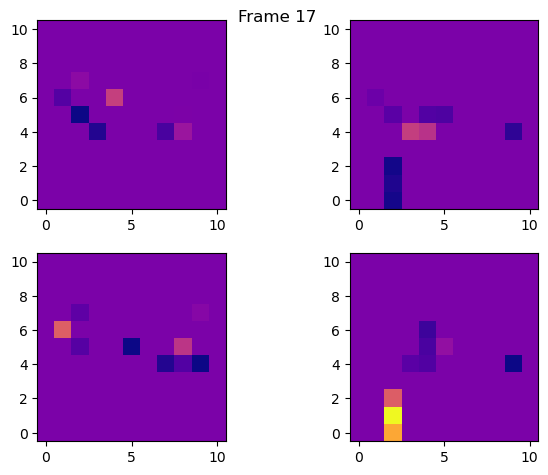

In [20]:
# Look at grid features for a shingle
grid = kcm_inputs['train_grid']
sample = kcm_inputs['train_data_chunks'][0][112]
tbins = sample['tbin_idx']
xbins = sample['xbin_idx']
ybins = sample['ybin_idx']
# Loop over each point in sample
grid_features = shape_utils.extract_grid_features(grid, tbins, xbins, ybins, n_prior=1, buffer=5)
shape_utils.save_grid_anim(grid_features, "grid_speeds_shingle.mp4", np.min(grid_features), np.max(grid_features))

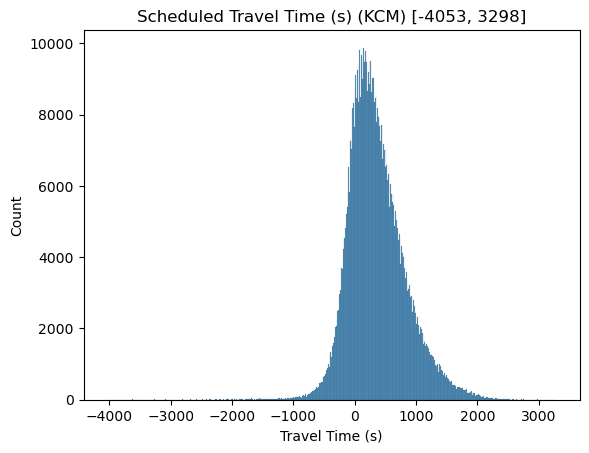

In [21]:
# Histogram of scheduled travel times
plot_data = kcm_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (KCM) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_scheduled_time_dist.png")

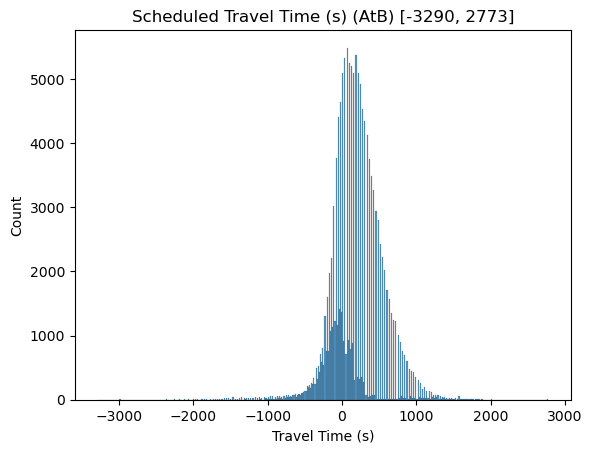

In [22]:
# Histogram of scheduled travel times
plot_data = atb_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (AtB) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_scheduled_time_dist.png")

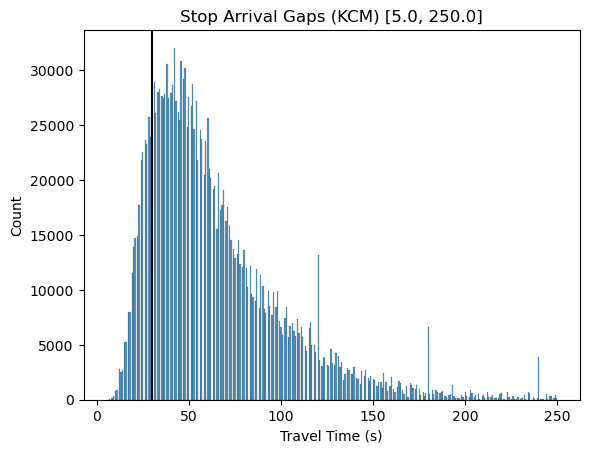

In [23]:
# Histogram of bus travel times in schedule
gtfs_data = kcm_inputs['gtfs_data']
x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (KCM) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/kcm_gtfs_arrival_gaps.png")

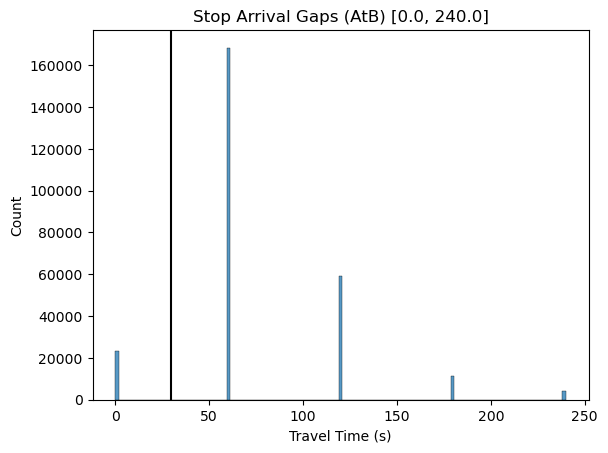

In [24]:
# Histogram of bus travel times in schedule
gtfs_data = atb_inputs['gtfs_data']

x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (AtB) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/atb_gtfs_arrival_gaps.png")

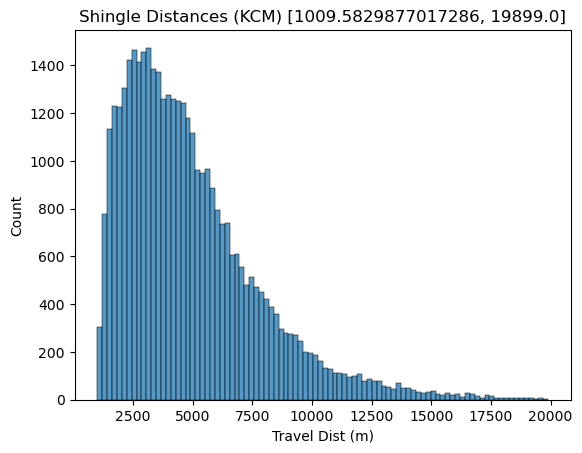

In [25]:
# Shingle distance
metric = kcm_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Dist (m)")
plt.savefig("../plots/kcm_shingle_dists.png")

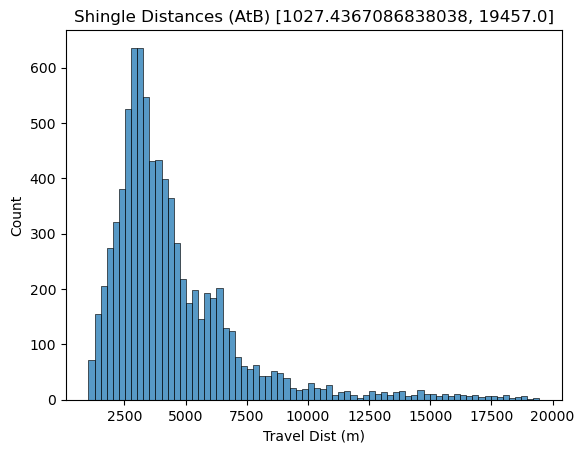

In [26]:
# Shingle distance
metric = atb_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Dist (m)")
plt.savefig("../plots/atb_shingle_dists.png")

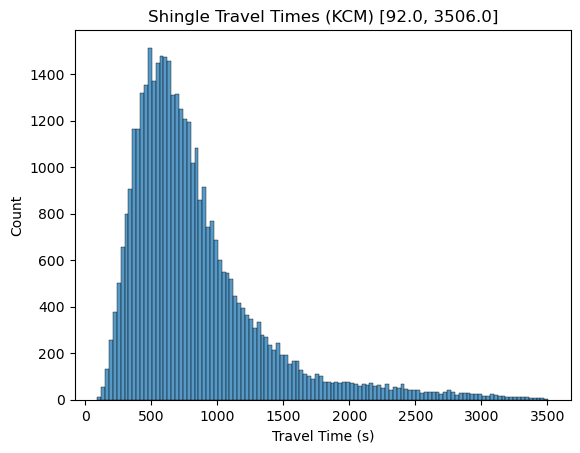

In [27]:
# Shingle travel time
metric = kcm_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_shingle_times.png")

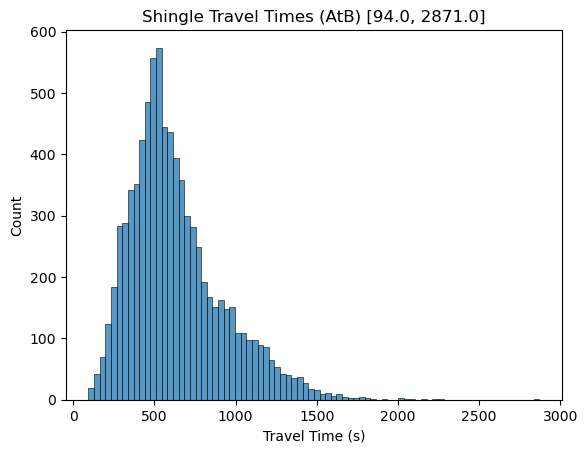

In [28]:
# Shingle travel time
metric = atb_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_shingle_times.png")

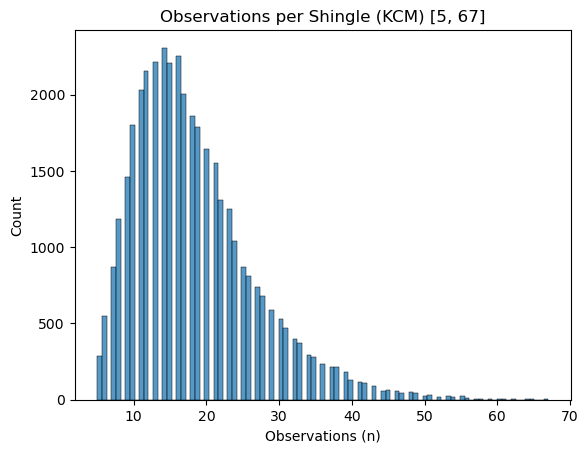

In [29]:
# Points per trajectory
metric = kcm_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/kcm_shingle_n.png")

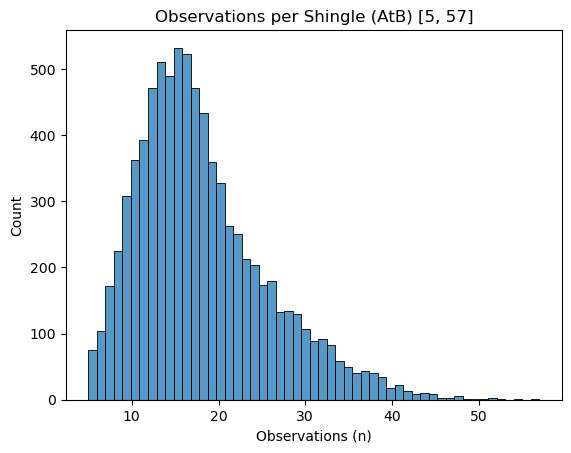

In [30]:
# Points per trajectory
metric = atb_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/atb_shingle_n.png")

In [ ]:
# Begin adjacent trip analysis (slow)

In [ ]:
kcm_grid = kcm_inputs['train_grid']
print(kcm_grid.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(kcm_grid)*1e-9)
shape_utils.save_grid_anim(kcm_grid, "grid_speeds_kcm.mp4", 0, 35)

In [ ]:
kcm_grid_ffill = kcm_inputs['train_grid_ffill']
print(kcm_grid_ffill.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(kcm_grid_ffill)*1e-9)
shape_utils.save_grid_anim(kcm_grid_ffill, "grid_speeds_ffill_kcm.mp4", 0, 35)

In [ ]:
atb_grid = atb_inputs['train_grid']
print(atb_grid.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(atb_grid)*1e-9)
shape_utils.save_grid_anim(atb_grid, "grid_speeds_atb.mp4", 0, 35)

In [ ]:
atb_grid_ffill = atb_inputs['train_grid_ffill']
print(atb_grid_ffill.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(atb_grid_ffill)*1e-9)
shape_utils.save_grid_anim(atb_grid_ffill, "grid_speeds_ffill_atb.mp4", 0, 35)

In [ ]:
# Look at speed correlation between adjacent bus trips
if NETWORK=="kcm":
    shingle_ids = pd.unique(kcm_inputs['test_traces']['shingle_id'])
    traces = kcm_inputs['test_traces']
else:
    shingle_ids = pd.unique(atb_inputs['test_traces']['shingle_id'])
    traces = atb_inputs['test_traces']
shingle_id_sample = np.random.choice(shingle_ids, 10, replace=False)
d_buffers = np.linspace(1,1000,20)
t_buffers = np.linspace(1,60*10,20)
b_buffer = 10
orthogonal = True
# Test shingle data against all other data
shingle_traces = traces[traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s','shingle_id']]
shingle_groups = shingle_traces.groupby('shingle_id')
adj_traces = traces[~traces['shingle_id'].isin(shingle_id_sample)][['x','y','locationtime','bearing','speed_m_s']].values
# Save results for each shingle, and buffer combination
targets_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))
preds_res = np.zeros((len(shingle_id_sample), len(d_buffers), len(t_buffers)))

In [ ]:
# Parallel: 5min with 10 samples, 20x20 buffers
def parallel_get_metrics(d):
    dist_buffer = d_buffers[d]
    results = []
    for t, t_buffer in enumerate(t_buffers):
        res = shingle_groups.apply(shape_utils.get_adjacent_metric, adj_traces, dist_buffer, t_buffer, b_buffer=b_buffer, orthogonal=orthogonal)
        targets = np.array([x[0] for x in res])
        preds = np.array([x[1] for x in res])
        # If all nan, fill with zeros
        if sum(~np.isnan(targets))==0:
            targets = np.nan_to_num(targets, nan=1.0)
        else:
            targets[np.isnan(targets)] = np.mean(targets[~np.isnan(targets)])
        # If some nan, fill with mean
        if sum(~np.isnan(preds))==0:
            preds = np.nan_to_num(preds, nan=1.0)
        else:
            preds[np.isnan(preds)] = np.mean(preds[~np.isnan(preds)])
        results.append((targets, preds, d, t))
    return results
# Each item in the results corresponds to a distance buffer; it has n subitems, 1 for each time buffer
# Within a d-t buffer, there are 4 values; (targets, preds, d_buffer idx, t_buffer idx)
res_parallel = Parallel(n_jobs=-2)(delayed(parallel_get_metrics)(x) for x in range(len(d_buffers)))

In [ ]:
# Expand parallel adjacent metric results
for d_idx in range(len(res_parallel)):
    for t_idx in range(len(res_parallel[0])):
        targets = res_parallel[d_idx][t_idx][0]
        preds = res_parallel[d_idx][t_idx][1]
        targets_res[:,d_idx,t_idx] = targets
        preds_res[:,d_idx,t_idx] = preds

In [ ]:
# Get R2 value for each combination of preds and targets and for each d and t buffer
r_values = np.empty((preds_res.shape[1], preds_res.shape[2]))
for d in range(preds_res.shape[1]):
    for t in range(preds_res.shape[2]):
        R2, x_plt, y_plt = shape_utils.fit_poly(preds_res[:,d,t], targets_res[:,d,t])
        r_values[d,t] = R2
r_values

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(r_values, origin="lower", cmap="plasma")
fig.suptitle("R2 of Polynomial Fit to Adjacent Trips")
ax.set_title(f"B={b_buffer} deg, Orth={str(orthogonal)}, Net={NETWORK}")
ax.set_xlabel("Time (s)")
ax.set_xticks([x for x in range(len(t_buffers))])
ax.set_xticklabels([str(int(x)) for x in t_buffers], rotation=45)
ax.set_ylabel("Distance (m)")
ax.set_yticks([y for y in range(len(d_buffers))])
ax.set_yticklabels([str(int(y)) for y in d_buffers])
cbar = fig.colorbar(im, ax=ax)
plt.draw()
plt.savefig(f"../plots/R2_poly_adj_small_{b_buffer}_{str(orthogonal)}_{NETWORK}.png")
plt.show()